In [11]:
from utils.instrument_recognition import feature_preparator
from models.instrument_recognition.FeedForwardSimpleModel import FeedForwardSimpleModel
import numpy as np
import torch
from utils.instrument_recognition import executor
from utils.instrument_recognition import plot_metrics
from utils.instrument_recognition import evaluate
from torch import nn
from utils.genre_classification import plot_confusion_matrix
from sklearn.metrics import classification_report

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
BATCH_SIZE = 16
DEVICE = torch.device('cuda')

In [4]:
dataloaders, idx_to_instrument = feature_preparator(8, transform = lambda x: np.mean(x, axis = 0))

In [5]:
train, val, test = dataloaders['accordion']

In [6]:
z = next(iter(train))
x = next(iter(val))
c = next(iter(test))

print(z[0].shape, z[1].shape)
print(x[0].shape, x[1].shape)
print(c[0].shape, c[1].shape)

torch.Size([8, 128]) torch.Size([8])
torch.Size([8, 128]) torch.Size([8])
torch.Size([8, 128]) torch.Size([8])


 37%|███▋      | 37/100 [00:19<00:33,  1.86it/s]

Early stop!


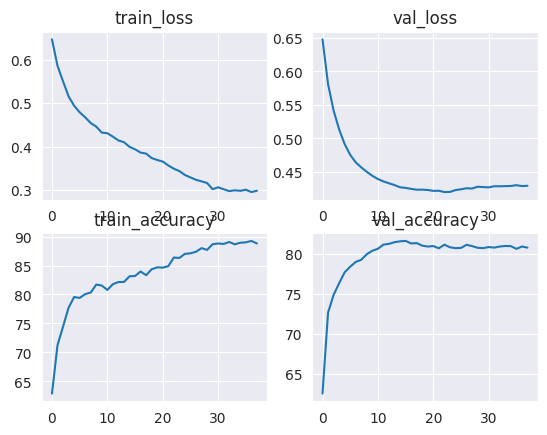

In [9]:
ff_simple_model = FeedForwardSimpleModel(128).to(DEVICE)
train_progress, val_progress = executor(DEVICE, ff_simple_model, train_dataloader = train, val_dataloader=val, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=20, early_stop_after=(15,  0.001))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

       False       0.84      0.95      0.89       225
        True       0.71      0.42      0.53        71

    accuracy                           0.82       296
   macro avg       0.78      0.68      0.71       296
weighted avg       0.81      0.82      0.80       296



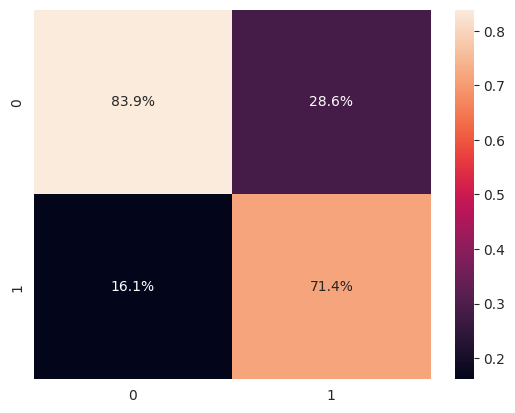

In [10]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, ff_simple_model, test, criterion=nn.BCEWithLogitsLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred)

In [16]:
for instrument in idx_to_instrument.values():
    model = FeedForwardSimpleModel(128).to(DEVICE)
    train, val, test = dataloaders[instrument]
    train_progress, val_progress = executor(
        DEVICE,
        model,
        train_dataloader=train,
        val_dataloader=val,
        epochs=100,
        learning_rate=0.0001,
        weight_decay=0.01,
        evaluate_per_iteration=20,
        early_stop_after=(15,  0.001)
    )
    test_loss, test_accuracy, (test_pred, test_true) = evaluate(
        DEVICE,
        model,
        test,
        criterion=nn.BCEWithLogitsLoss(),
        return_pred=True
    )

    # Строим classification_report для тренировочного и тестового датасета
    print('-' * 52)
    print(instrument)

    print('\tTEST')
    print(classification_report(test_true.cpu(), test_pred.cpu(), zero_division=0))


 43%|████▎     | 43/100 [00:16<00:21,  2.66it/s]


Early stop!
----------------------------------------------------
accordion
	TEST
              precision    recall  f1-score   support

       False       0.84      0.92      0.87       225
        True       0.62      0.44      0.51        71

    accuracy                           0.80       296
   macro avg       0.73      0.68      0.69       296
weighted avg       0.79      0.80      0.79       296



 36%|███▌      | 36/100 [00:15<00:26,  2.39it/s]


Early stop!
----------------------------------------------------
banjo
	TEST
              precision    recall  f1-score   support

       False       0.87      0.74      0.80       187
        True       0.57      0.76      0.65        85

    accuracy                           0.75       272
   macro avg       0.72      0.75      0.73       272
weighted avg       0.78      0.75      0.75       272



 29%|██▉       | 29/100 [00:09<00:23,  3.07it/s]


Early stop!
----------------------------------------------------
bass
	TEST
              precision    recall  f1-score   support

       False       0.91      0.86      0.88       220
        True       0.57      0.68      0.62        60

    accuracy                           0.82       280
   macro avg       0.74      0.77      0.75       280
weighted avg       0.84      0.82      0.83       280



 44%|████▍     | 44/100 [00:14<00:18,  3.01it/s]


Early stop!
----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.74      0.80      0.77       150
        True       0.79      0.72      0.75       154

    accuracy                           0.76       304
   macro avg       0.76      0.76      0.76       304
weighted avg       0.76      0.76      0.76       304



 30%|███       | 30/100 [00:13<00:31,  2.24it/s]


Early stop!
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.82      0.90      0.86       307
        True       0.43      0.27      0.33        85

    accuracy                           0.76       392
   macro avg       0.62      0.58      0.59       392
weighted avg       0.73      0.76      0.74       392



 55%|█████▌    | 55/100 [00:14<00:12,  3.70it/s]


Early stop!
----------------------------------------------------
cymbals
	TEST
              precision    recall  f1-score   support

       False       0.97      0.84      0.90        82
        True       0.93      0.99      0.96       174

    accuracy                           0.94       256
   macro avg       0.95      0.91      0.93       256
weighted avg       0.94      0.94      0.94       256



 45%|████▌     | 45/100 [00:12<00:14,  3.68it/s]


Early stop!
----------------------------------------------------
drums
	TEST
              precision    recall  f1-score   support

       False       0.94      0.85      0.90        96
        True       0.91      0.97      0.94       152

    accuracy                           0.92       248
   macro avg       0.93      0.91      0.92       248
weighted avg       0.92      0.92      0.92       248



 35%|███▌      | 35/100 [00:12<00:22,  2.85it/s]


Early stop!
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.77      0.86      0.81       226
        True       0.61      0.46      0.53       110

    accuracy                           0.73       336
   macro avg       0.69      0.66      0.67       336
weighted avg       0.72      0.73      0.72       336



100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


----------------------------------------------------
guitar
	TEST
              precision    recall  f1-score   support

       False       0.92      0.92      0.92        98
        True       0.95      0.95      0.95       166

    accuracy                           0.94       264
   macro avg       0.94      0.94      0.94       264
weighted avg       0.94      0.94      0.94       264



 39%|███▉      | 39/100 [00:11<00:17,  3.40it/s]


Early stop!
----------------------------------------------------
mallet_percussion
	TEST
              precision    recall  f1-score   support

       False       0.88      0.66      0.76       169
        True       0.65      0.87      0.74       119

    accuracy                           0.75       288
   macro avg       0.76      0.77      0.75       288
weighted avg       0.78      0.75      0.75       288



 26%|██▌       | 26/100 [00:11<00:33,  2.19it/s]


Early stop!
----------------------------------------------------
mandolin
	TEST
              precision    recall  f1-score   support

       False       0.84      0.83      0.84       244
        True       0.66      0.67      0.66       116

    accuracy                           0.78       360
   macro avg       0.75      0.75      0.75       360
weighted avg       0.78      0.78      0.78       360



 31%|███       | 31/100 [00:10<00:23,  2.91it/s]


Early stop!
----------------------------------------------------
organ
	TEST
              precision    recall  f1-score   support

       False       0.79      0.90      0.84       190
        True       0.66      0.45      0.54        82

    accuracy                           0.76       272
   macro avg       0.73      0.68      0.69       272
weighted avg       0.75      0.76      0.75       272



 40%|████      | 40/100 [00:11<00:17,  3.49it/s]


Early stop!
----------------------------------------------------
piano
	TEST
              precision    recall  f1-score   support

       False       0.94      0.87      0.90        69
        True       0.95      0.98      0.97       195

    accuracy                           0.95       264
   macro avg       0.95      0.92      0.93       264
weighted avg       0.95      0.95      0.95       264



 48%|████▊     | 48/100 [00:20<00:22,  2.34it/s]


Early stop!
----------------------------------------------------
saxophone
	TEST
              precision    recall  f1-score   support

       False       0.85      0.70      0.77       191
        True       0.72      0.86      0.78       169

    accuracy                           0.78       360
   macro avg       0.79      0.78      0.78       360
weighted avg       0.79      0.78      0.78       360



 46%|████▌     | 46/100 [00:11<00:13,  3.89it/s]


Early stop!
----------------------------------------------------
synthesizer
	TEST
              precision    recall  f1-score   support

       False       0.89      0.80      0.84        50
        True       0.94      0.97      0.95       158

    accuracy                           0.93       208
   macro avg       0.91      0.88      0.90       208
weighted avg       0.93      0.93      0.93       208



 31%|███       | 31/100 [00:17<00:37,  1.82it/s]


Early stop!
----------------------------------------------------
trombone
	TEST
              precision    recall  f1-score   support

       False       0.90      0.85      0.87       293
        True       0.61      0.71      0.65        99

    accuracy                           0.81       392
   macro avg       0.75      0.78      0.76       392
weighted avg       0.82      0.81      0.82       392



 31%|███       | 31/100 [00:17<00:40,  1.72it/s]


Early stop!
----------------------------------------------------
trumpet
	TEST
              precision    recall  f1-score   support

       False       0.84      0.77      0.80       288
        True       0.62      0.72      0.67       152

    accuracy                           0.75       440
   macro avg       0.73      0.75      0.74       440
weighted avg       0.77      0.75      0.76       440



 41%|████      | 41/100 [00:17<00:25,  2.32it/s]


Early stop!
----------------------------------------------------
ukulele
	TEST
              precision    recall  f1-score   support

       False       0.85      0.80      0.82       247
        True       0.61      0.68      0.64       113

    accuracy                           0.76       360
   macro avg       0.73      0.74      0.73       360
weighted avg       0.77      0.76      0.77       360



 46%|████▌     | 46/100 [00:14<00:17,  3.14it/s]


Early stop!
----------------------------------------------------
violin
	TEST
              precision    recall  f1-score   support

       False       0.74      0.70      0.72       120
        True       0.87      0.89      0.88       280

    accuracy                           0.83       400
   macro avg       0.81      0.80      0.80       400
weighted avg       0.83      0.83      0.83       400



 53%|█████▎    | 53/100 [00:13<00:11,  4.06it/s]

Early stop!
----------------------------------------------------
voice
	TEST
              precision    recall  f1-score   support

       False       0.89      0.89      0.89        96
        True       0.90      0.91      0.91       112

    accuracy                           0.90       208
   macro avg       0.90      0.90      0.90       208
weighted avg       0.90      0.90      0.90       208

